In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import illustris_python as il

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
def get_median_escape(df, edges, mass_type, mode='mean', f_esc_loc=1.0):
    medians = []
    error = []
    for i in range(len(edges)-1):
        sub_df = df[(edges[i]*(1-1e-10)<df[mass_type]) & (df[mass_type]<edges[i+1])]
        sub_esc = sub_df['Q0']*sub_df['f_esc']*f_esc_loc
        if mode == 'median':
            medians.append(sub_esc.median())
        elif mode == 'mean':
            medians.append(sub_esc.mean())
        error.append(sub_esc.std()/np.sqrt(len(sub_esc)))
#         root_n = np.sqrt(len(sub_esc)) 
#         std = sub_esc.std()
#         median = sub_esc.median()
    return np.array(medians), np.array(error)

def get_tng_masses(mass_type, snap):
    basePath = '/virgotng/universe/IllustrisTNG/L35n2160TNG/output'
    if mass_type == 'StarMass':
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMassType')[:,4]/h
    elif mass_type == 'HaloMass':
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMass')/h
    else:
        raise ValueError(f'"mass_type" has to be "StarMass" or "GroupMass" received {mass_type} instead')
    return masses

def get_esc_dens(df, redshift, bins, mode='mean', mass_type='StarMass', mass_cut=None):
    redshift_map = {6:13, 8:8, 10:4}
    box_size=35.
    tng_masses = get_tng_masses(mass_type, snap=redshift_map[redshift])
    
    if mass_cut != None:
        mass_min = mass_cut
    else:
        mass_min = tng_masses[tng_masses!=0].min()
    #mass_max = tng_masses.max()
    mass_max = df[mass_type].max()
    edges = np.logspace(np.log10(mass_min),np.log10(mass_max), bins)
    
    centroids = []
    widths = []
    for i in range(len(edges)-1):
        centroids.append(edges[i]/2+edges[i+1]/2)
        widths.append(edges[i+1]-edges[i])
    centroids = np.array(centroids)
    widths = np.array(widths)
    hist, _ = np.histogram(tng_masses, bins=edges)
    hist_norm = hist/box_size**3
    
    median_esc, esc_err = get_median_escape(df[df.z==redshift], edges, mass_type,  mode='mean')
    dens_esc = median_esc*hist_norm
    dens_err = esc_err*hist_norm
    
    hist_used = hist_norm[np.logical_not(np.isnan(median_esc))]
    centroids_used = centroids[np.logical_not(np.isnan(median_esc))]
    widths_used = widths[np.logical_not(np.isnan(median_esc))]
    
    used = [centroids_used, hist_used, widths_used]
    all_hist = [centroids, hist_norm, widths]
    uv_escape = [centroids, dens_esc, dens_err, widths_used]
    return used, all_hist, uv_escape

In [4]:
def plot_esc_dens(df, redshift=6, bins=50, mass_type='StarMass', save=False):
    used, all_hist, uv_escape = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
    if mass_type == 'StarMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{star})[M_\mathrm{sun}]$'
    elif mass_type == 'HaloMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{halo})[M_\mathrm{sun}]$'
        
    fig, ax1 = plt.subplots()
    fig.suptitle(f'z={redshift}', fontsize=30)

    x_used = np.log10(np.array(used[0])*mult)
    x_all = np.log10(np.array(all_hist[0])*mult)
    width = x_used[1]-x_used[0]
    ax1.bar(x_all, all_hist[1], width=width, label='all halos')#, width=np.log10(np.array(all_hist[2])*mult))
    ax1.bar(x_used, used[1], width=width, label='halos used in simulations')#, width=np.log10(np.array(used[2])*mult))
    ax1.tick_params(length=10, width=3)
    ax1.tick_params(length=5, width=2, which='minor')
    ax1.set_yscale('log')
    ax1.set_ylabel('$n_\mathrm{clusters}[\mathrm{cMpc}^{-3}]$', size=45)
    ax1.set_xlabel(x_label, size=45)
    ax1.set_xlim(5.0,9.5)
    ax1.legend(fontsize=35)
    plt.rc('axes', linewidth=2)
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.rcParams["figure.figsize"] = (15,15)
    
    if save:
        path = f'/u/ivkos/analysis/plots/halo_density_z{redshift}.pdf'
        plt.savefig(path)
    
#     ax2 = ax1.twinx()
#     ax2.errorbar(uv_escape[0], uv_escape[1], yerr=uv_escape[2], linewidth=3, elinewidth=1, capsize=10, color='black')
#     ax2.tick_params(length=10, width=3)
#     ax2.tick_params(length=5, width=2, which='minor')
#     ax2.set_yscale('log')
#     ax2.set_ylabel('$N_\gamma[s^{-1}\mathrm{cMpc}^{-3}]$', size=30);
    return

In [5]:
def get_esc_uv(df, redshift, bins, mass_type, mass_cut):
    _, _, uv_esc = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type, mass_cut = mass_cut)
    
    centroids = uv_esc[0]
    escaped_photons = np.array(uv_esc[1])
    escaped_error = uv_esc[2]
    widths_used = uv_esc[3]
    
    cumulative_values = []
    cumulative_error = []
    summed_value = 0
    for j,element in enumerate(escaped_photons):
        if np.isnan(element):
            element = 0
        summed_value += element
        summed_error = np.sqrt(np.nansum(np.square(escaped_error[:j+1])))
        cumulative_values.append(summed_value)
        cumulative_error.append(summed_error)
    escaped_photons_cum = np.array(cumulative_values)
    escaped_error_cum = np.array(cumulative_error)
    
    escaped_uv = np.log10(escaped_photons)
    escaped_uv_cum = np.log10(escaped_photons_cum)
    err_uv = escaped_error/(np.log(10)*escaped_photons)
    return centroids, escaped_uv, err_uv, escaped_uv_cum

In [6]:
def plot_z_esc(df, redshifts=[6,8,10], bins=50, mass_type='StarMass', cumulative=False, lower_ylim=49, upper_ylim=50.6, lower_ylim_cum=49, upper_ylim_cum=52, save=False, mass_cut=None):
    
    labelsize = 60
    ticksize = 45
    linewidth = 5
    errorwidth = 3
    capsize = 10
    legendsize = 50
    axes_width = 3
    plot_width = 25
    plot_height = 20
    major_tick_length = 10
    major_tick_width = 3
    minor_tick_length = 5
    minor_tick_width = 2
    
    fig_width = 45
    fig_height = 60
    
    cutoff_halo_mass = 25
    
    lower_ylim = lower_ylim
    upper_ylim = upper_ylim
    
    if mass_type == 'StarMass':
        mult = 1e10
        x_label = '$\log(M_\star)[\log(M_{\u2609})]$'
        x_label2 = '$\log(M_\mathrm{vir})[\log(M_{\u2609})]$'
    elif mass_type == 'HaloMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{vir})[\log(M_{\u2609})]$'
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)
    plt.subplots_adjust(wspace=0.001)
    ax1 = plt.subplot2grid((2, 1), (0,0))
    ax2 = plt.subplot2grid((2, 1), (1,0), sharex=ax1)
    for redshift in redshifts:
        centroids, escaped_uv, err_uv, escaped_uv_cum =  get_esc_uv(df, redshift=redshift, bins=bins, mass_type=mass_type, mass_cut=mass_cut)
        
        #centroids_vir, escaped_uv_vir, err_uv_vir, escaped_uv_cum_vir =  get_esc_uv(df, redshift=redshift, bins=bins, mass_type=mass_type, cumulative=cumulative)
#         if mass_type == 'StarMass':
        ax1.errorbar(np.log10(np.array(centroids)*mult), escaped_uv, yerr=err_uv, 
                     linewidth=linewidth, elinewidth=errorwidth, capsize=capsize, label=f'z={redshift}')
        ax2.plot(np.log10(np.array(centroids)*mult), escaped_uv_cum, linewidth=linewidth, label=f'z={redshift}')
#         if cumulative:
#             ax1.plot(np.log10(np.array(centroinds)*mult), escaped_uv, linewidth=linewidth, label=f'z={redshift}')
#             ax2.plot(np.log10(np.array(centroids_vir)*mult), escaped_uv_vir, linewidth=linewidth, label=f'z={redshift}')
#         else:
#             ax1.errorbar(np.log10(np.array(centroids_vir)*mult), escaped_uv_vir, yerr=err_uv_vir, 
#                          linewidth=linewidth, elinewidth=errorwidth, capsize=capsize, label=f'z={redshift}')
#             ax2.plot(np.log10(np.array(centroids_vir)*mult), escaped_uv_cum_vir, linewidth=linewidth, label=f'z={redshift}')
    
    ax1.set_ylim(lower_ylim, upper_ylim)
#     if cumulative:
    y_label_cum = r'$\log(\dot{N}_\mathrm{ion}(<M_*))[s^{-1}\mathrm{cMpc}^{-3}]$'
#     else:
    y_label = r'$\log(\dot{N}_\mathrm{ion})[s^{-1}\mathrm{cMpc}^{-3}]$'
    
    ax1.set_ylabel(y_label, size=labelsize)
    ax2.set_ylabel(y_label_cum, size=labelsize)
    ax2.set_xlabel(x_label, size=labelsize)
    #ax2.set_xlabel(x_label2, size=labelsize)
    ax2.legend(fontsize=legendsize)
    
    plt.rcParams["figure.figsize"] = (plot_width,plot_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    plt.tick_params(length=major_tick_length, width=major_tick_width)
    plt.tick_params(length=minor_tick_length, width=minor_tick_width, which='minor')
    plt.rcParams["figure.figsize"] = (fig_width,fig_height)
    
    if save:
        if cumulative:
            appendix = 'cumulative'
        else:
            appendix = ''
        path = f'/u/ivkos/analysis/plots/uv_{mass_type}_{appendix}.pdf'
        plt.savefig(path, bbox_inches = 'tight')

In [7]:
def plot_uv_redshift(df, redshifts=[6,8,10], bins=50, mass_type='StarMass',log=False, save=False):
    tot_uv = []
    tot_uv_err = []
        
    for redshift in redshifts:
        _, _, uv_esc = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
        tot_uv.append(np.sum(uv_esc[1][~np.isnan(uv_esc[1])]))
        err_not_nan = uv_esc[2][~np.isnan(uv_esc[2])]
        uv_err = np.sqrt(np.sum(np.square(np.array(err_not_nan))))
        tot_uv_err.append(uv_err)
        
    if log:
        y_label = r'$\log(\dot{N}_\mathrm{ion})[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'
        uv_err = np.array(uv_err)/(np.log(10)*np.array(tot_uv))
        tot_uv = np.log10(np.array(tot_uv))
    else:
        y_label = r'$\dot{N}_\mathrm{ion}[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'

    print(tot_uv)
    print(uv_err)
    plt.errorbar(redshifts, tot_uv, yerr=uv_err, marker='s', linewidth=3, elinewidth=1, capsize=10, markersize=25, linestyle='--')
    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=35) 
    plt.rc('ytick', labelsize=35) 
    plt.tick_params(length=10, width=3)
    plt.tick_params(length=5, width=2, which='minor')
    
    plt.xlabel('z', size=45)
    plt.ylabel(y_label, size=45)
    if save:
        path = f'/u/ivkos/analysis/plots/uv_z.pdf'
        plt.savefig(path)

In [8]:
def plot_scatter_color(df, y_prop='Q0', y_label=None, save = False):

    redshifts = [6,8,10]
    for redshift in redshifts:
        sub_df = df[df.z==redshift]
        x_values = np.log10(np.array(sub_df['StarMass'])*1e6)
        y_values = np.log10(np.array(sub_df[y_prop]))
        plt.scatter(x_values, y_values, label=f'z={redshift}')
    
    x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    if y_label == None:
        y_label = y_prop
    else:
        y_label = y_label
            
    
    plt.xlabel(x_label, size=35)
    plt.ylabel(y_label, size=35)
    plt.tick_params(length=16, width=4)
    plt.tick_params(length=8, width=3, which='minor')
    plt.legend(fontsize=35)

    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rcParams["figure.figsize"] = (20,20)
    
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/all_data_scatter.pdf')
    plt.show();
    return

In [9]:
def update_df(df, h=0.6774):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']/h
    df['HaloMass']= df['HaloMass']/h
    return

In [10]:
anderson_vulcan_z = [6,7,8,10]
anderson_vulcan_values = [50.85, 50.78, 50.6, 50.48]
anderson_vulcan_upper = [51.0, 51., 50.95, 50.9]
anderson_vulcan_lower = [50.5, 50.3, 49.9, 49.15]

bouwens_z = [6,7,8,9,10]
bouwens_upper = [51.15, 50.9, 50.7, 50.6, 50.5]
bouwens_lower = [50.7, 50.6, 50.5, 50.4, 50.1]

eide_z = [6,7,8,9,10]
eide_values = [51.2, 51., 51.2, 50.95, 50.9]

bouwens_2005_z = [7.5,10]
bouwens_2005_z_err = [1.,1.2]
bouwens_2005_values = [49.5,49.2]
bouwens_2005_upper = [49.7,49.2]
bouwens_2005_lower = [0,0]

richard_2006_z = [7.7,8.7]
richard_2006_z_err = [1.,2.]
richard_2006_values = [50.9,51.1]
richard_2006_upper = [50.9,51.1]
richard_2006_lower = [0,0]

stark_2007_z = [9.2]
stark_2007_z_err = [0.7]
stark_2007_values = [51.6]
stark_2007_upper = [51.6]
stark_2007_lower = [0]

naidu_2019_z = [6,7,8,9,10]
naidu_2019_values_model_1 = [51.2,51,50.5,50.2,49.8]
naidu_2019_values_model_2 = [51.1,51,50.4,50.1,49.6]

mason_2019_z = [6,7,8,9,10]
mason_2019_upper = [51.6,50.9,50.6,50.4,50.3]
mason_2019_lower = [50.8,50.5,50.1,49.7,49.3]

tng_z = [6, 8, 10]
tng_values = [51.75091434, 51.442638, 51.05641301]
tng_errors = [0.00282946, 0.00575413, 0.01400247]

ocvirk_2021_z = [6, 7, 8, 9, 10]
ocvirk_2021_fiducial = np.log10(1e50*np.array([4, 3.5, 3, 2.5, 2]))
ocvirk_2021_permissive = np.log10(1e50*np.array([5, 4, 2.8, 1.9, 1.5]))

finkelstein_2019_z = [6,7,8,9,10]
finkelstein_2019_values = [50.6, 50.6, 50.65, 50.7, 50.8]

comparison = {}
comparison['tng'] = {}
comparison['bouwens'] = {}
comparison['eide'] = {}
comparison['bouwens2005'] = {}
comparison['richard'] = {}
comparison['stark'] = {}
comparison['naidu1'] = {}
comparison['naidu2'] = {}
comparison['mason'] = {}
comparison['anderson'] = {}
comparison['ocvirk'] = {}
comparison['finkelstein'] = {}

comparison['tng']['z'] = tng_z
comparison['bouwens']['z'] = bouwens_z
comparison['eide']['z'] = eide_z
comparison['bouwens2005']['z'] = bouwens_2005_z
comparison['richard']['z'] = richard_2006_z
comparison['stark']['z'] = stark_2007_z
comparison['naidu1']['z'] = naidu_2019_z
comparison['naidu2']['z'] = naidu_2019_z
comparison['mason']['z'] = mason_2019_z
comparison['anderson']['z'] = anderson_vulcan_z
comparison['ocvirk']['z'] = ocvirk_2021_z
comparison['finkelstein']['z'] = finkelstein_2019_z

comparison['tng']['label'] = 'TNG50'
comparison['bouwens']['label'] = 'Bouwens 2015'
comparison['eide']['label'] = 'Eide 2020'
comparison['bouwens2005']['label'] = 'Bouwens 2005'
comparison['richard']['label'] = 'Richard 2006'
comparison['stark']['label'] = 'Stark 2007'
comparison['naidu1']['label'] = 'Naidu 2019 (Model I)'
comparison['naidu2']['label'] = 'Naidu 2019 (Model II)'
comparison['mason']['label'] = 'Mason 2019'
comparison['anderson']['label'] = 'Anderson 2017'
comparison['ocvirk']['label_1'] = 'Ocvirk 2021 (Model I)'
comparison['ocvirk']['label_2'] = 'Ocvirk 2021 (Model II)'
comparison['finkelstein']['label'] = 'Finkelstein 2019'

comparison['tng']['mode'] = 'tng'
comparison['eide']['mode'] = 'normal'
comparison['bouwens2005']['mode'] = 'limit'
comparison['richard']['mode'] = 'limit'
comparison['stark']['mode'] = 'limit'
comparison['naidu1']['mode'] = 'normal'
comparison['naidu2']['mode'] = 'normal'
comparison['mason']['mode'] = 'shade'
comparison['bouwens']['mode'] = 'shade'
comparison['anderson']['mode'] = 'error shade'
comparison['ocvirk']['mode'] = 'normal'

comparison['mason']['upper'] = mason_2019_upper
comparison['bouwens']['upper'] = bouwens_upper
comparison['anderson']['upper'] = anderson_vulcan_upper
comparison['mason']['lower'] = mason_2019_lower
comparison['bouwens']['lower'] = bouwens_lower
comparison['anderson']['lower'] = anderson_vulcan_lower

comparison['tng']['value'] = tng_values
comparison['eide']['value'] = eide_values
comparison['bouwens2005']['value'] = bouwens_2005_values
comparison['richard']['value'] = richard_2006_values
comparison['stark']['value'] = stark_2007_values
comparison['naidu1']['value'] = naidu_2019_values_model_1
comparison['naidu2']['value'] = naidu_2019_values_model_2
comparison['anderson']['value'] = anderson_vulcan_values
comparison['ocvirk']['value_1'] = ocvirk_2021_fiducial
comparison['ocvirk']['value_2'] = ocvirk_2021_permissive
comparison['finkelstein']['value'] = finkelstein_2019_values

comparison['bouwens2005']['z_err'] = bouwens_2005_z_err
comparison['richard']['z_err'] = richard_2006_z_err
comparison['stark']['z_err'] = stark_2007_z_err
comparison['bouwens2005']['marker'] = 'o'
comparison['richard']['marker'] = 's'
comparison['stark']['marker'] = 'H'

comparison['bouwens2005']['up_lim'] = bouwens_2005_upper
comparison['richard']['up_lim'] = richard_2006_upper
comparison['stark']['up_lim'] = stark_2007_upper
comparison['anderson']['up_lim'] = anderson_vulcan_upper

comparison['bouwens2005']['low_lim'] = bouwens_2005_lower
comparison['richard']['low_lim'] =  richard_2006_lower
comparison['stark']['low_lim'] = stark_2007_lower
comparison['anderson']['low_lim'] = anderson_vulcan_lower

comparison['tng']['y_err'] = tng_errors

In [12]:
def plot_comparisons(dictionary, save=False):
    fig_width = 20
    fig_height = 20
    labelsize = 60
    ticksize = 45
    linewidth = 4
    capsize=8
    legendsize = 27
    axes_width = 3
    plot_width = 25
    plot_height = 20
    major_tick_length = 10
    major_tick_width = 3
    minor_tick_length = 5
    minor_tick_width = 2
    alpha = 0.8
    markersize = 15
    
    x_values = dictionary['tng']['z']
    y_values = dictionary['tng']['value']
    error_values = dictionary['tng']['y_err']
    label = dictionary['tng']['label']
    #plt.errorbar(x_values, y_values, yerr=error_values, linewidth=linewidth, capsize=capsize, label=label)
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['bouwens2005']['z']
    y_values = dictionary['bouwens2005']['value']
    up_values = dictionary['bouwens2005']['up_lim']
    low_values = dictionary['bouwens2005']['low_lim']
    z_err = dictionary['bouwens2005']['z_err']
    label = dictionary['bouwens2005']['label']
    marker = dictionary['bouwens2005']['marker']
    # This is just a setting for the downward pointing arrow
    y_err = np.array(y_values)*0.003
    plt.errorbar(x_values, y_values, yerr=y_err, xerr=z_err, marker=marker, markersize=markersize, linewidth=linewidth, linestyle='None', color='dimgrey', capsize=capsize, uplims=True,label=label)
    
    x_values = dictionary['richard']['z']
    y_values = dictionary['richard']['value']
    up_values = dictionary['richard']['up_lim']
    low_values = dictionary['richard']['low_lim']
    z_err = dictionary['richard']['z_err']
    label = dictionary['richard']['label']
    marker = dictionary['richard']['marker']
    # This is just a setting for the downward pointing arrow
    y_err = np.array(y_values)*0.003
    plt.errorbar(x_values, y_values, yerr=y_err, xerr=z_err, marker=marker, markersize=markersize, linewidth=linewidth, linestyle='None', color='dimgrey', capsize=capsize, uplims=True,label=label)
    
    x_values = dictionary['stark']['z']
    y_values = dictionary['stark']['value']
    up_values = dictionary['stark']['up_lim']
    low_values = dictionary['stark']['low_lim']
    z_err = dictionary['stark']['z_err']
    label = dictionary['stark']['label']
    marker = dictionary['stark']['marker']
    # This is just a setting for the downward pointing arrow
    y_err = np.array(y_values)*0.003
    plt.errorbar(x_values, y_values, yerr=y_err, xerr=z_err, marker=marker, markersize=markersize, linewidth=linewidth, linestyle='None', color='dimgrey', capsize=capsize, uplims=True,label=label)
        
    x_values = dictionary['naidu1']['z']
    y_values = dictionary['naidu1']['value']
    label = dictionary['naidu1']['label']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['finkelstein']['z']
    y_values = dictionary['finkelstein']['value']
    label = dictionary['finkelstein']['label']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['naidu2']['z']
    y_values = dictionary['naidu2']['value']
    label = dictionary['naidu2']['label']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['ocvirk']['z']
    y_values = dictionary['ocvirk']['value_1']
    label = dictionary['ocvirk']['label_1']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['ocvirk']['z']
    y_values = dictionary['ocvirk']['value_2']
    label = dictionary['ocvirk']['label_2']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
        
    x_values = np.array(dictionary['mason']['z'])+0.05
    y_values_low = dictionary['mason']['lower']
    y_values_high = dictionary['mason']['upper']
    y_values_mid = (np.array(y_values_high)+np.array(y_values_low))/2.
    y_error = y_values_high-y_values_mid
    label = dictionary['mason']['label']
    plt.errorbar(x_values, y_values_mid, yerr=y_error, label=label, color='dimgrey', fmt='D', capsize=capsize, alpha=alpha, markersize=markersize, linewidth=linewidth)
    
    x_values = dictionary['bouwens']['z']
    y_values_low = dictionary['bouwens']['lower']
    y_values_high = dictionary['bouwens']['upper']
    y_values_mid = (np.array(y_values_high)+np.array(y_values_low))/2.
    y_error = y_values_high-y_values_mid
    label = dictionary['bouwens']['label']
    plt.errorbar(x_values, y_values_mid, yerr=y_error, label=label, color='dimgrey', fmt='^', capsize=capsize, alpha=alpha, markersize=markersize, linewidth=linewidth)
        
    x_values = dictionary['anderson']['z']
    y_values = dictionary['anderson']['value']
    y_err_low = np.array(y_values)-np.array(dictionary['anderson']['lower'])
    y_err_high = np.array(dictionary['anderson']['upper'])-np.array(y_values)
    y_err = np.array([y_err_low, y_err_high])
    label = dictionary['anderson']['label']
    #plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    plt.errorbar(x_values, y_values, yerr=y_err, linewidth=linewidth, capsize=capsize, marker='o', label=label)
        
    plt.legend(fontsize=legendsize)
    x_label = 'z'
    y_label = r'$\dot{N}_\mathrm{ion}[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'
    plt.rcParams["figure.figsize"] = (fig_height, fig_width)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    plt.tick_params(length=major_tick_length, width=major_tick_width)
    plt.tick_params(length=minor_tick_length, width=minor_tick_width, which='minor')

    plt.xlabel('z', size=labelsize)
    plt.ylabel(y_label, size=labelsize)
    plt.xlabel(x_label, size=labelsize)
    plt.xlim(5.9,10.1)
    if save:
        path = f'/u/ivkos/analysis/plots/comparisons.pdf'
        plt.savefig(path)

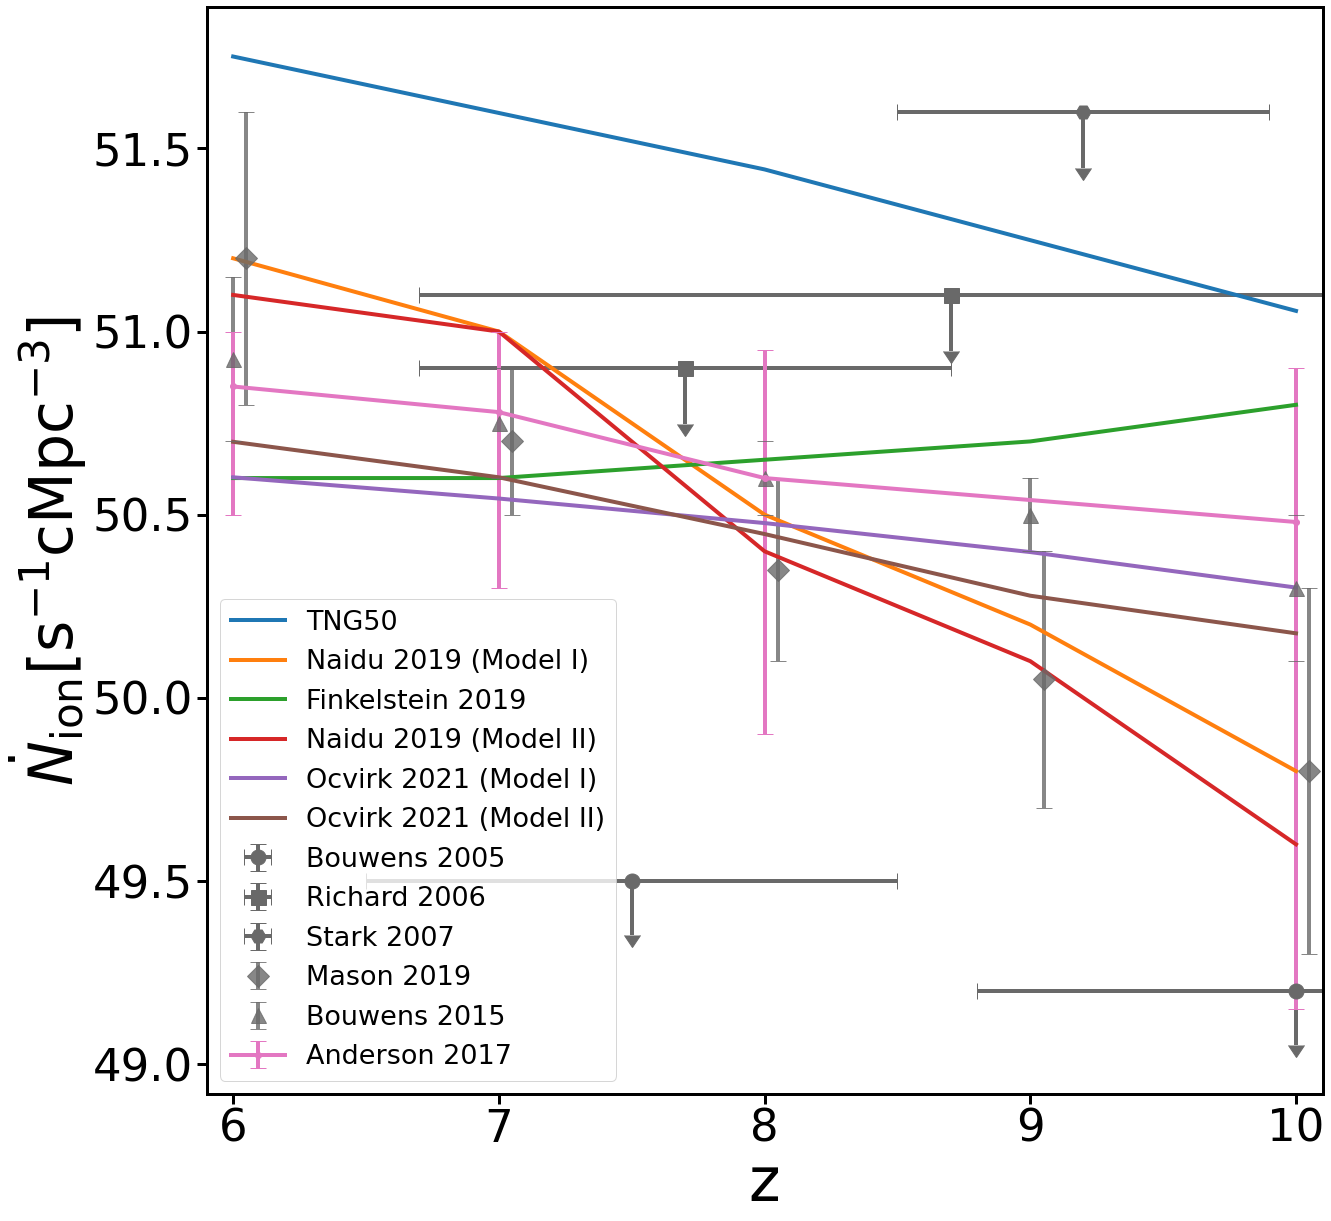

In [38]:
plot_comparisons(comparison, save=True)

In [14]:
comparison['tng']['mode'] = 'tng'
comparison['eide']['mode'] = 'normal'
comparison['bouwens2005']['mode'] = 'limit'
comparison['richard']['mode'] = 'limit'
comparison['stark']['mode'] = 'limit'
comparison['naidu1']['mode'] = 'normal'
comparison['naidu2']['mode'] = 'normal'
comparison['mason']['mode'] = 'shade'
comparison['bouwens']['mode'] = 'shade'
comparison['anderson']['mode'] = 'error shade'

In [15]:
df = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(df)

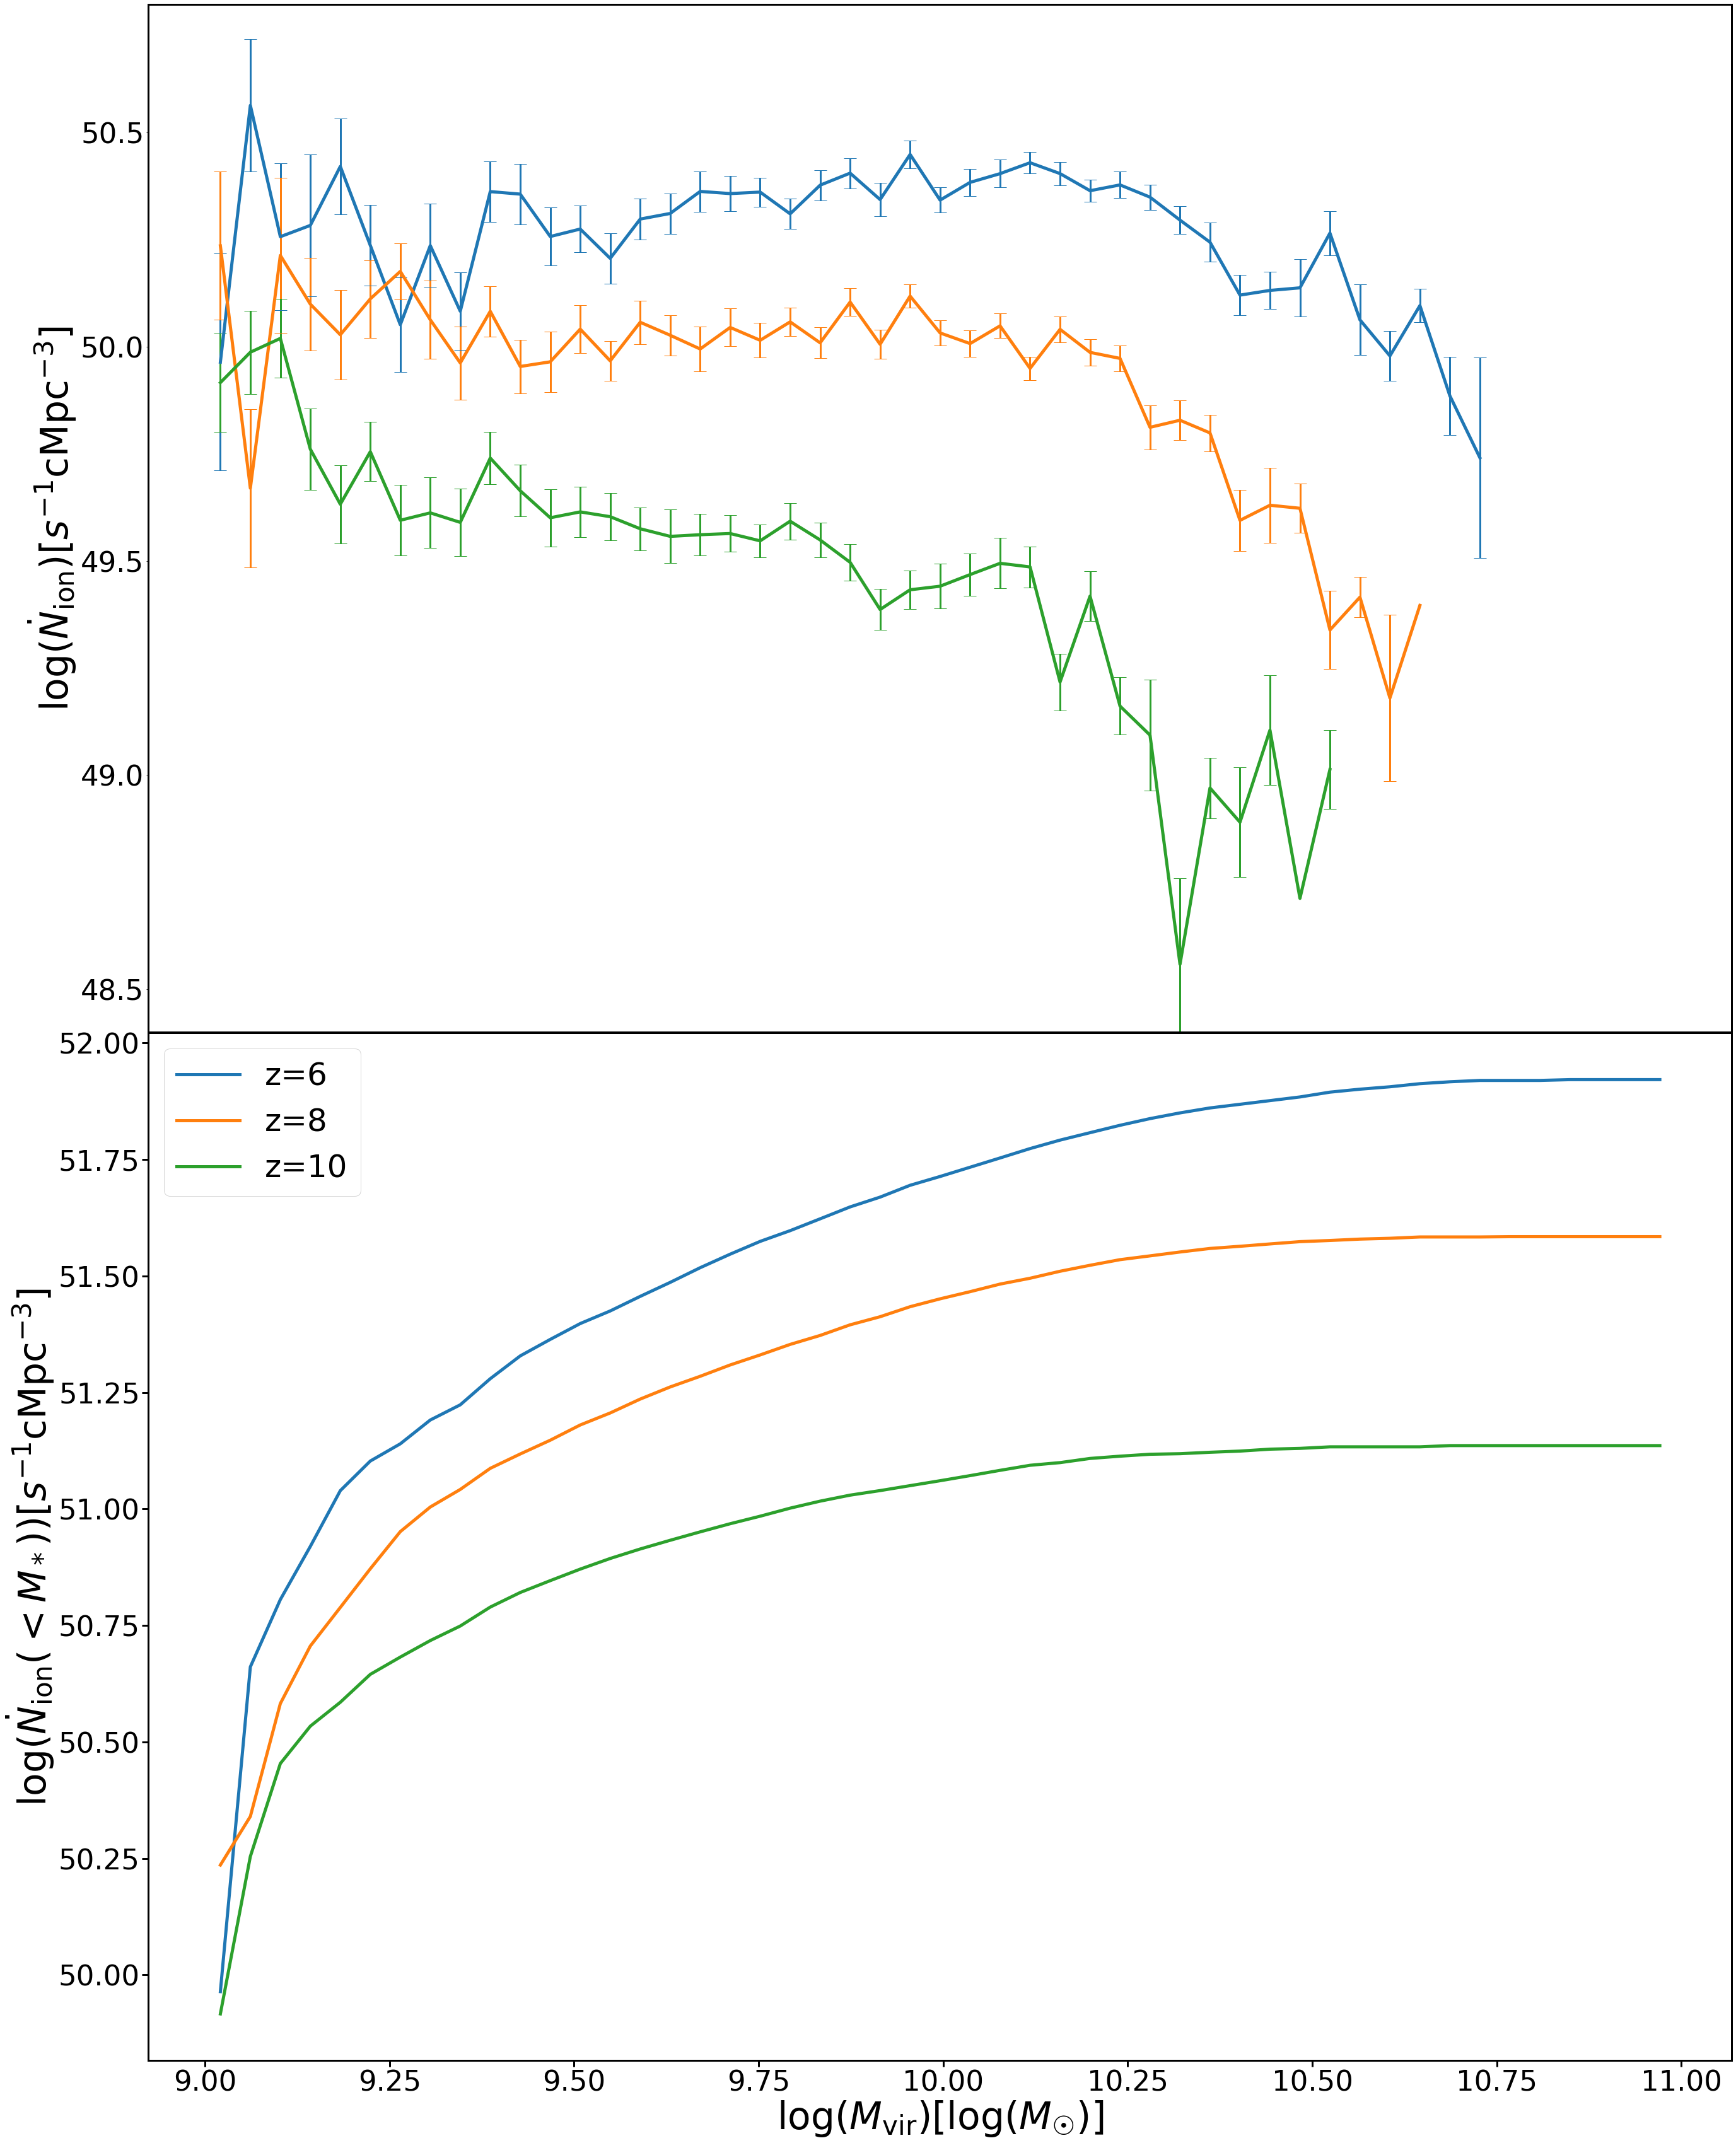

In [57]:
plot_z_esc(df, save=True, mass_type='HaloMass', cumulative=False, mass_cut=1e-1, lower_ylim=48.4, upper_ylim=50.8)

[51.75091434 51.442638   51.05641301]
[0.00282946 0.00575413 0.01400247]


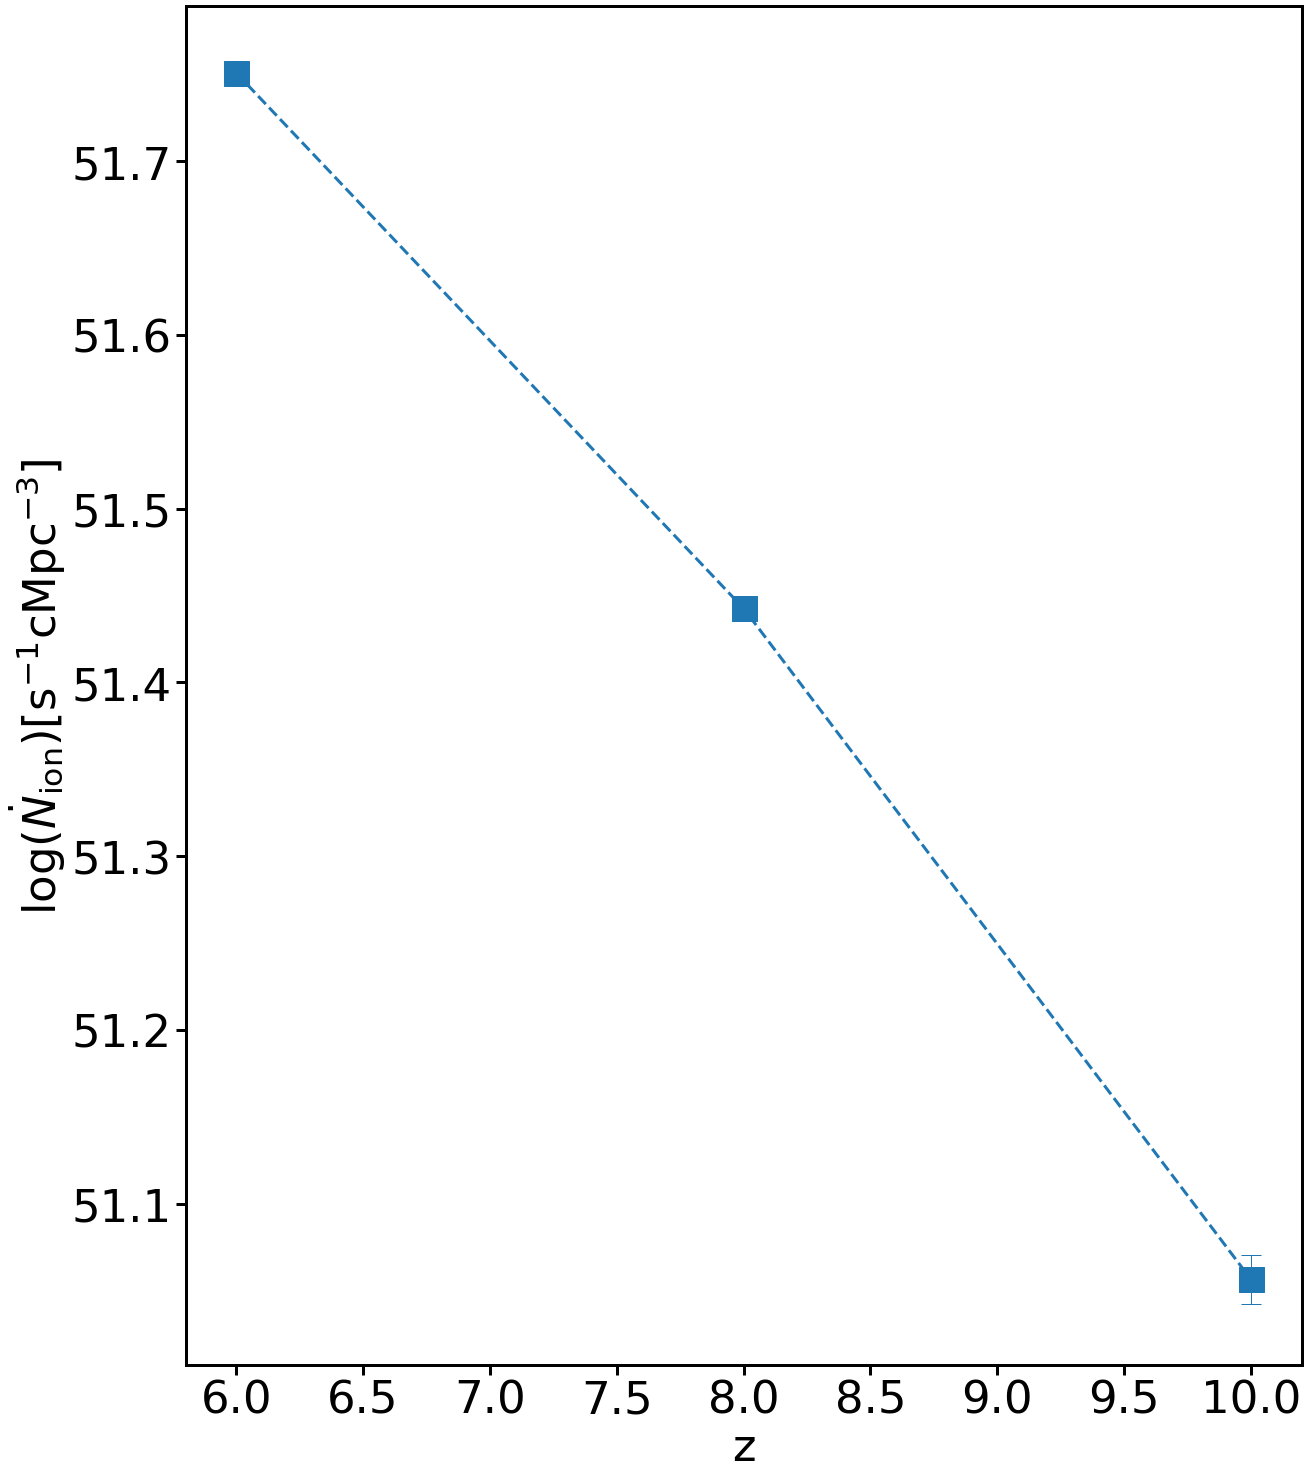

In [47]:
plot_uv_redshift(df, redshifts=[6,8,10], bins=50, mass_type='StarMass', log=True, save=False)

[ 8.68324253  8.77184932  8.86045612  8.94906292  9.03766972  9.12627652
  9.21488332  9.30349012  9.39209692  9.48070371  9.56931051  9.65791731
  9.74652411  9.83513091  9.92373771 10.01234451 10.1009513  10.1895581
 10.2781649  10.3667717  10.4553785  10.5439853  10.6325921  10.7211989 ]
[ 8.69197937  8.78021359  8.8684478   8.95668201  9.04491623  9.13315044
  9.22138466  9.30961887  9.39785308  9.4860873   9.57432151  9.66255572
  9.75078994  9.83902415  9.92725837 10.01549258 10.10372679 10.19196101
 10.28019522 10.36842943 10.45666365 10.54489786 10.63313208 10.72136629]
[ 8.71259664  8.79995164  8.88730663  8.97466163  9.06201663  9.14937163
  9.23672663  9.32408163  9.41143663  9.49879163  9.58614663  9.67350163
  9.76085662  9.84821162  9.93556662 10.02292162 10.11027662 10.19763162
 10.28498662 10.37234162 10.45969662 10.54705162 10.63440661 10.72176161]


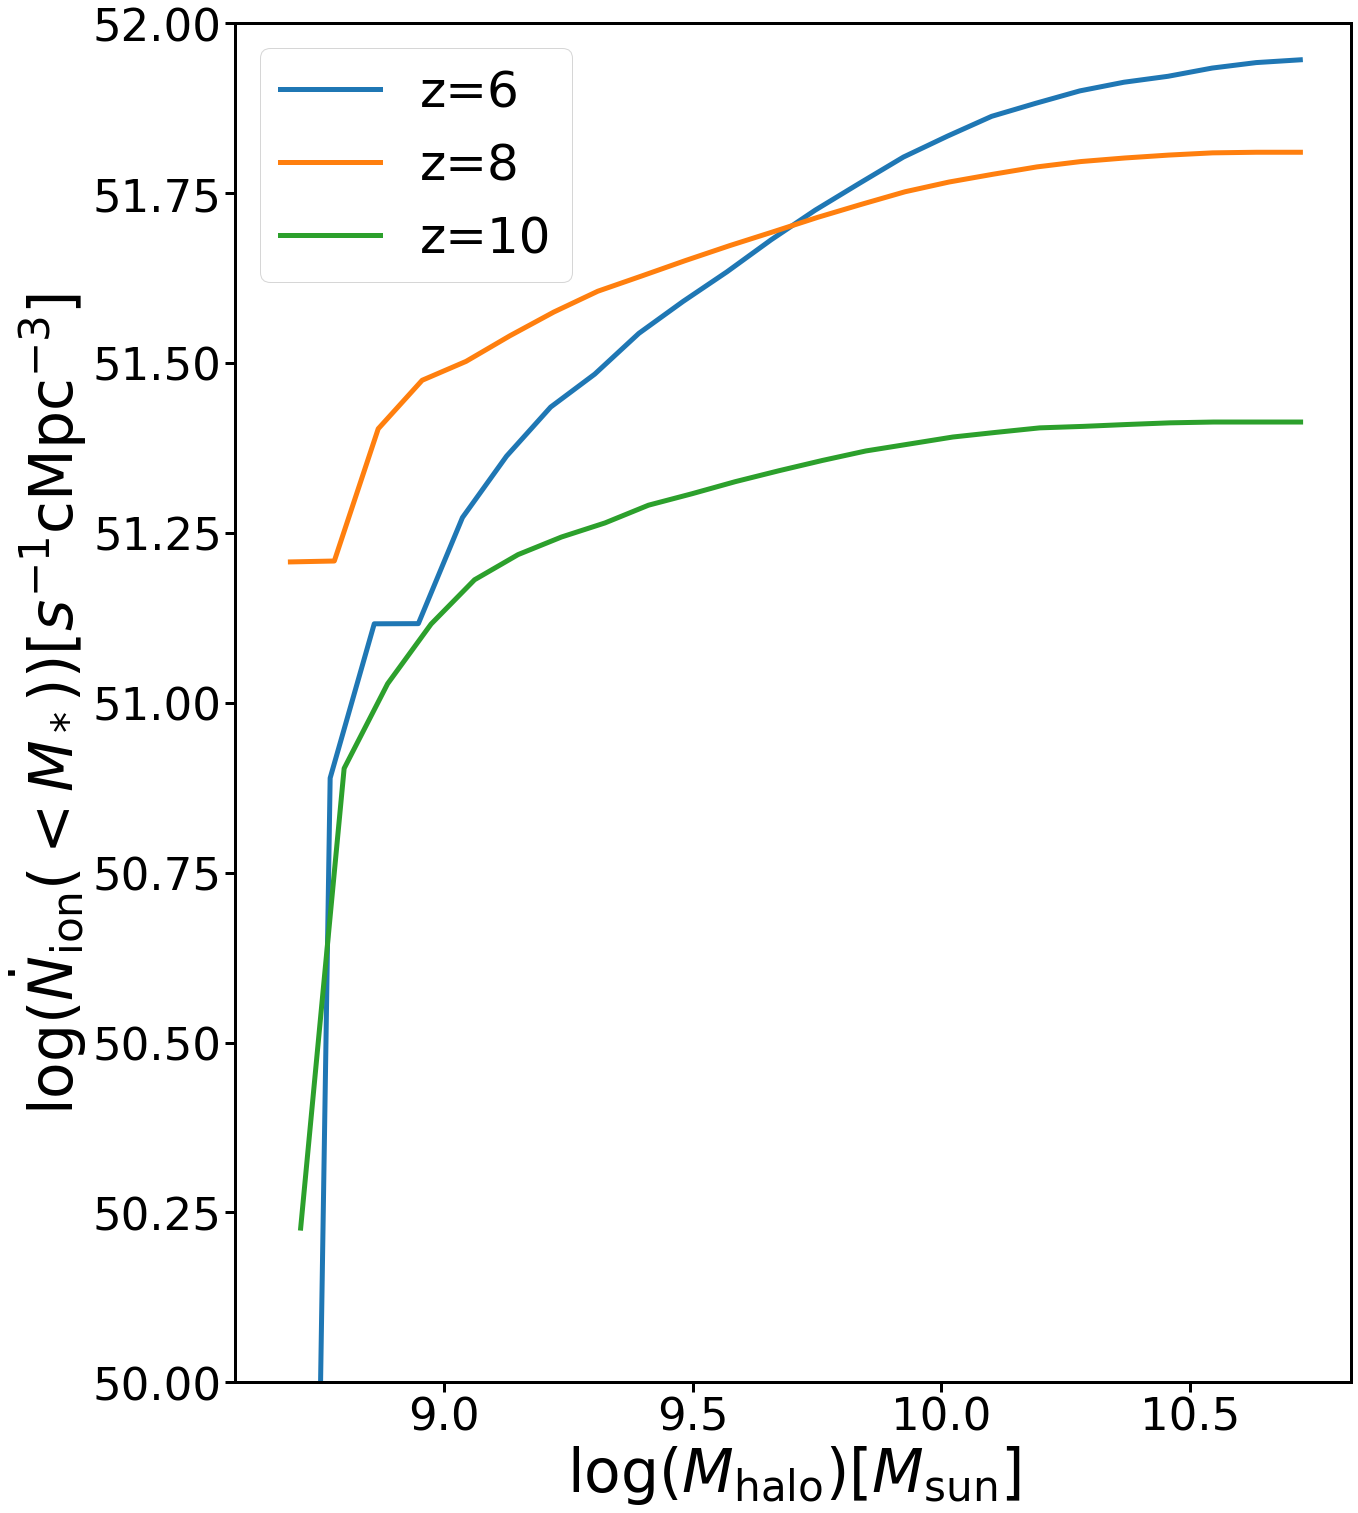

In [43]:
plot_z_esc(df,save=True, mass_type='HaloMass', lower_ylim=50, upper_ylim=52, cumulative=True)

[4.30542787 4.38132251 4.45721714 4.53311178 4.60900642 4.68490106
 4.7607957  4.83669033 4.91258497 4.98847961 5.06437425 5.14026888
 5.21616352 5.29205816 5.3679528  5.44384743 5.51974207 5.59563671
 5.67153135 5.74742599 5.82332062 5.89921526 5.9751099  6.05100454
 6.12689917 6.20279381 6.27868845 6.35458309 6.43047773 6.50637236
 6.582267   6.65816164 6.73405628 6.80995091 6.88584555 6.96174019
 7.03763483 7.11352947 7.1894241  7.26531874 7.34121338 7.41710802
 7.49300265 7.56889729 7.64479193 7.72068657 7.79658121 7.87247584
 7.94837048]
[4.26906041 4.34570557 4.42235073 4.49899589 4.57564105 4.65228621
 4.72893137 4.80557653 4.88222169 4.95886685 5.03551201 5.11215717
 5.18880233 5.26544749 5.34209265 5.41873781 5.49538297 5.57202813
 5.64867329 5.72531845 5.80196361 5.87860877 5.95525393 6.03189909
 6.10854425 6.18518941 6.26183457 6.33847973 6.41512489 6.49177005
 6.56841521 6.64506037 6.72170553 6.79835069 6.87499585 6.95164101
 7.02828617 7.10493133 7.18157649 7.25822165 7.33

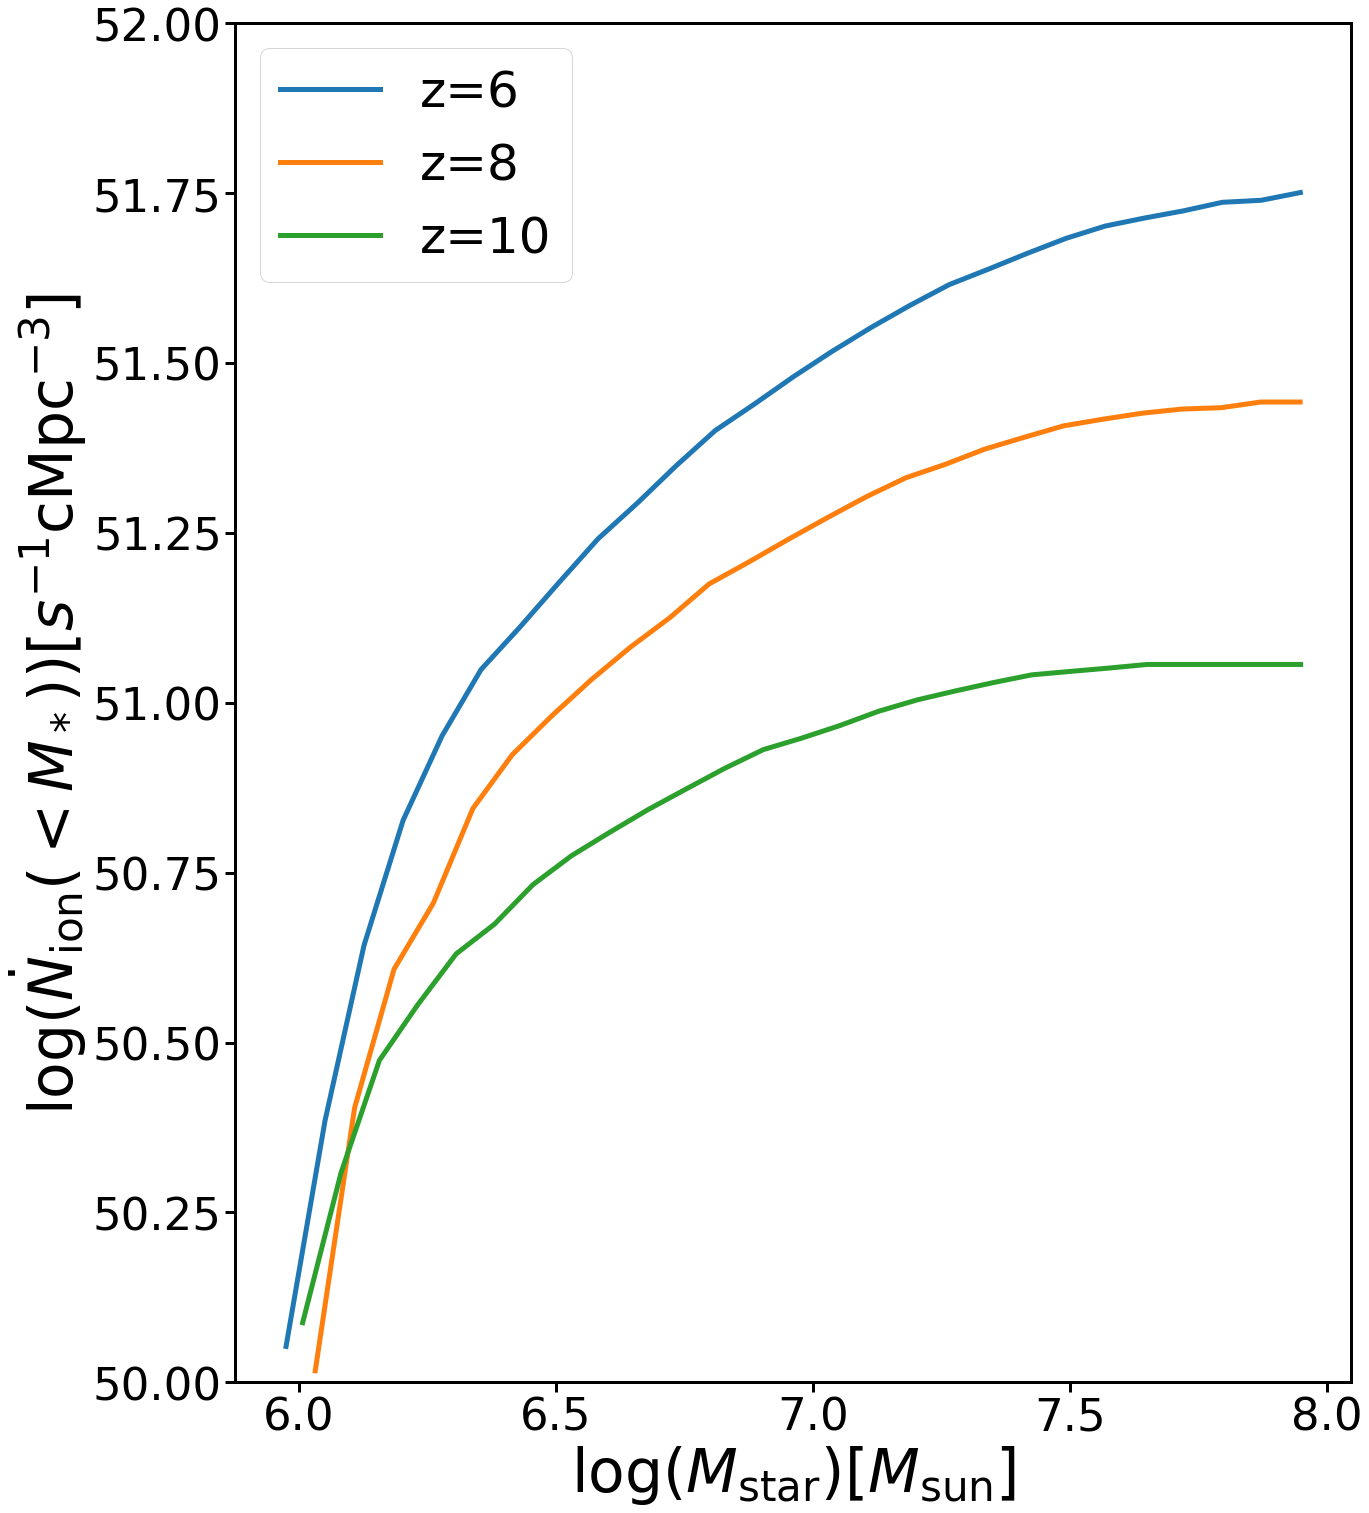

In [42]:
plot_z_esc(df,save=True, mass_type='StarMass', lower_ylim=50, upper_ylim=52, cumulative=True)

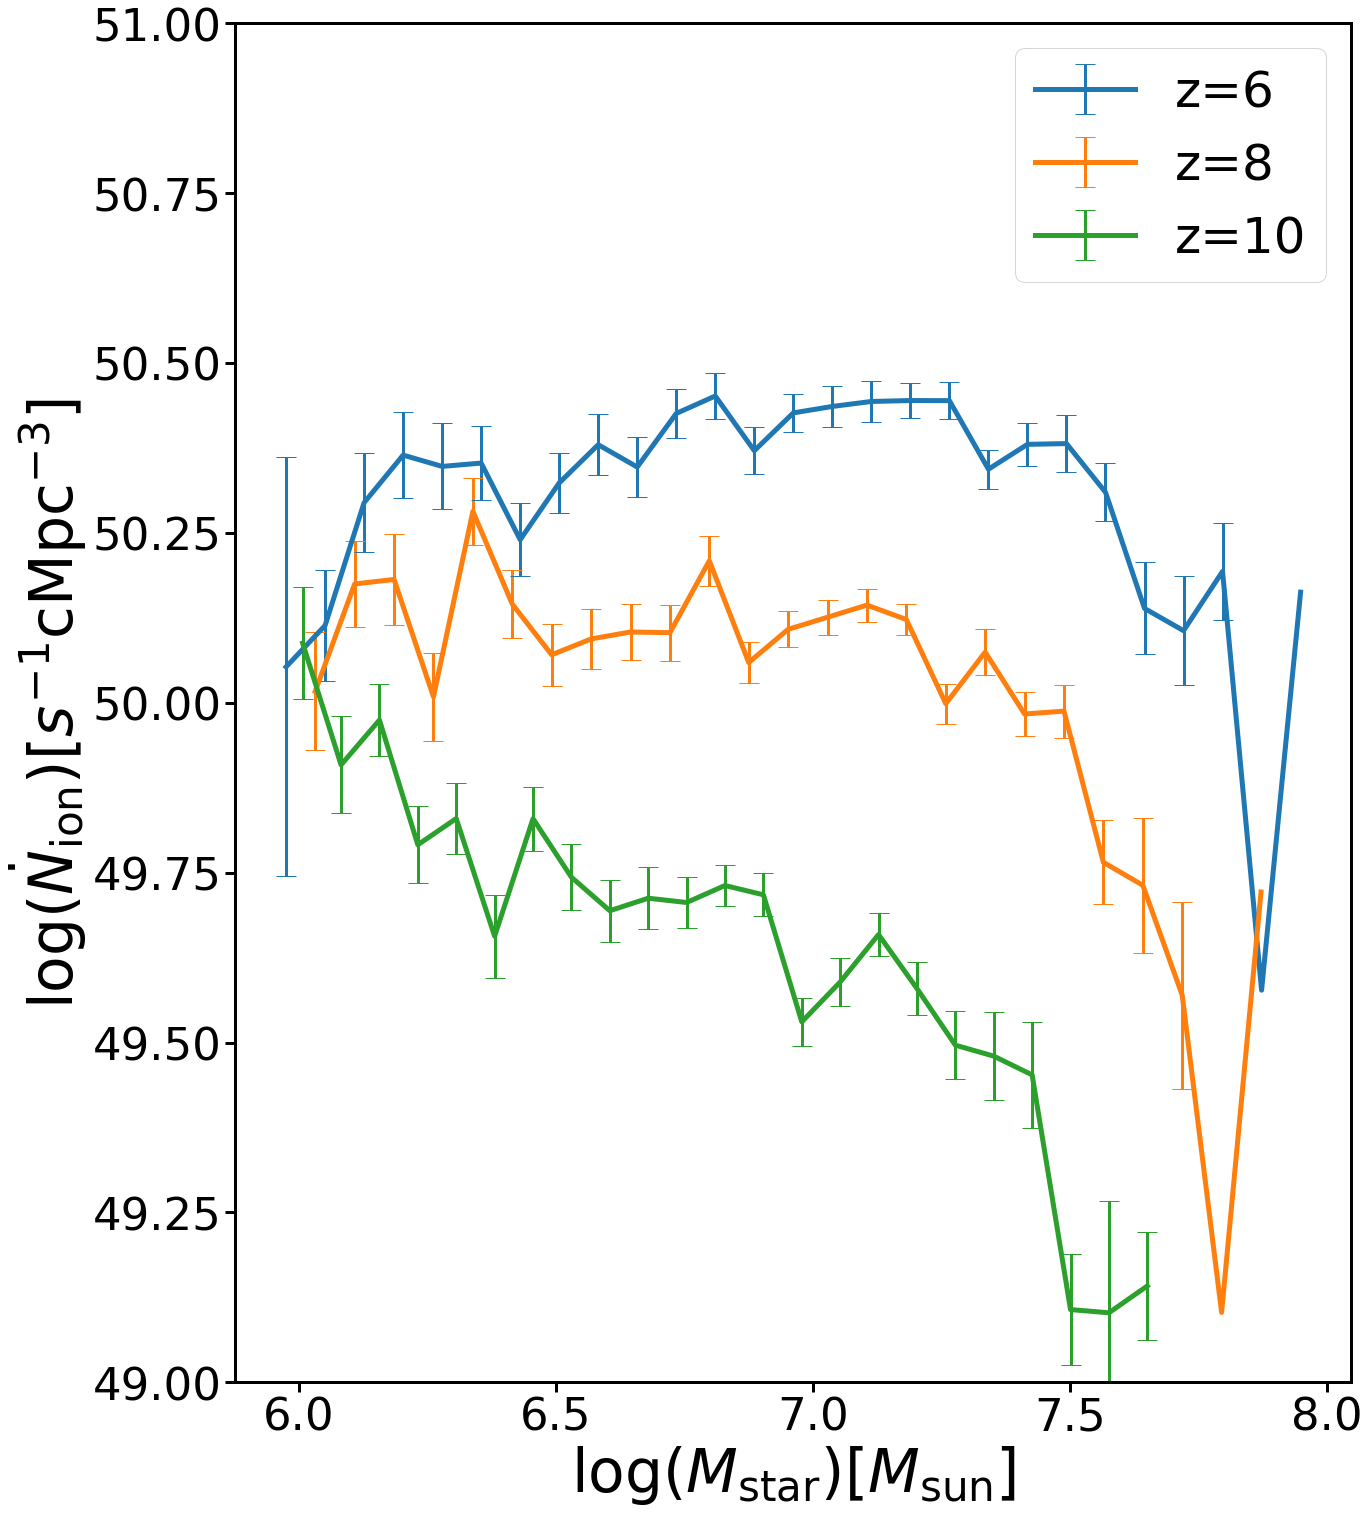

In [44]:
plot_z_esc(df,save=True, mass_type='StarMass', lower_ylim=49, upper_ylim=51, cumulative=False)

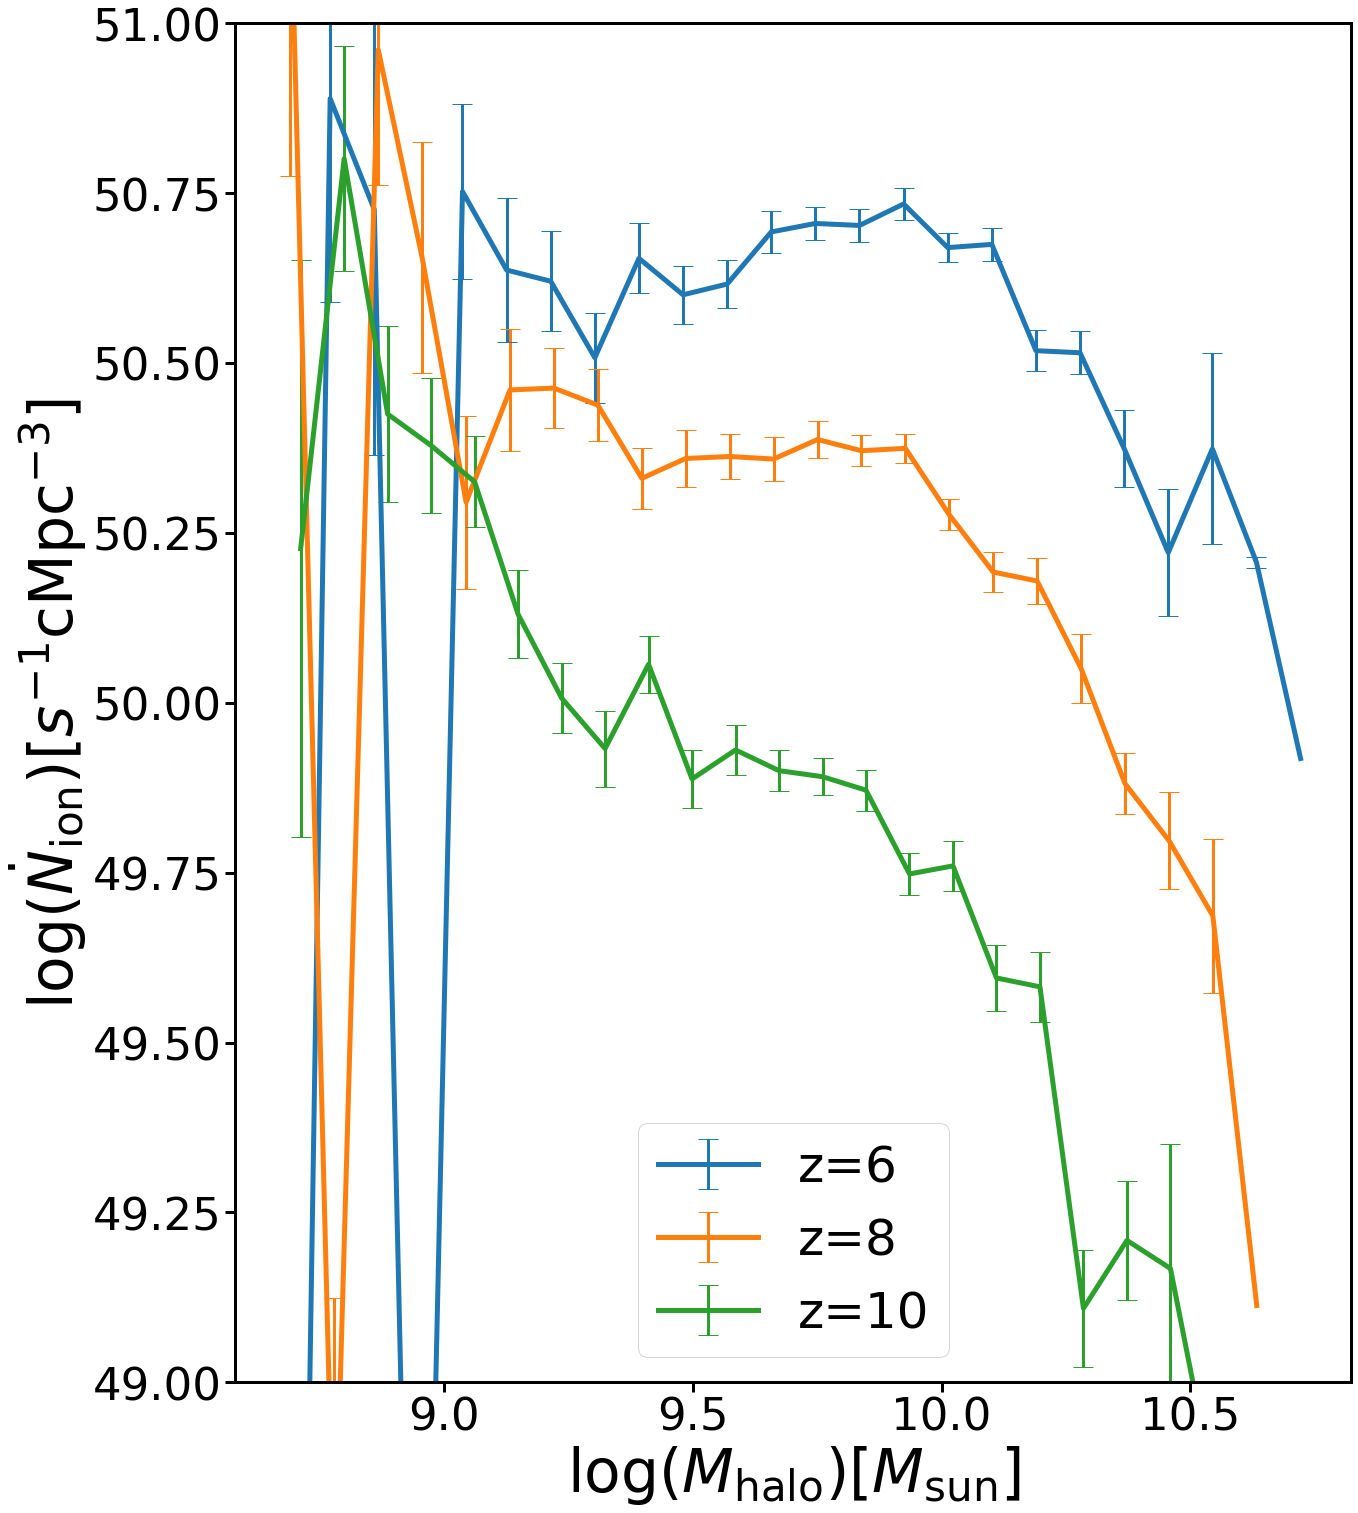

In [45]:
plot_z_esc(df,save=True, mass_type='HaloMass', lower_ylim=49, upper_ylim=51, cumulative=False)